# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-03-09 18:26:47 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.8

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


In [ ]:
using BenchmarkTools

M = rand(2^11, 2^11)

@btime $M * $M;

  496.413 ms (2 allocations: 32.00 MiB)


In [ ]:
try
    using CUDA
catch
    println("No GPU found.")
else
    run(`nvidia-smi`)
    # Create a new random matrix directly on the GPU:
    M_on_gpu = CUDA.CURAND.rand(2^11, 2^11)
    @btime $M_on_gpu * $M_on_gpu; nothing
end

No GPU found.


In [ ]:
using Pkg
Pkg.add("Graphs")
Pkg.add("GraphIO")
Pkg.add("Plots")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
⌅ [91a5bcdd] + Plots v1.39.0
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
using GraphIO.NET
using Graphs

file_path = "/content/Networks/real/dolphins.net"
network=Graphs.loadgraph(file_path, "graph_key", NETFormat())

# Reading the .net file
#graph = GraphIO.loadgraph(file_path, GraphIO.PajekFormat())

{62, 159} undirected simple Int64 graph

In [ ]:
# First working version

using Plots

# Function to calculate the degree probability distribution function
function degree_pdf(graph, num_bins::Int=2, log_plot::Bool=false, CCDF::Bool:false)

    degree_counts = Graphs.degree_histogram(graph)

    # Calculate probabilities
    num_nodes = nv(graph)


    pdf = Dict(degree => count / num_nodes for (degree, count) in degree_counts)

    degrees = collect(keys(pdf))
    probabilities = collect(values(pdf))

    if CCDF
      # Calculate CCDF
      ccdf_values = 1.0 .- cumsum(probabilities)

      if log_plot
        plot = histogram(degrees, weights=ccdf_values, xlabel="Log Degree (K)", ylabel="Comp. Cum. Probability (P(K))", legend=false, bins=num_bins, yscale=:log10)
      else
        plot = histogram(degrees, weights=ccdf_values, xlabel="Log Degree (K)", ylabel="Comp. Cum. Probability (P(K))", legend=false, bins=num_bins)
      end


    else
    #plot=histogram(degrees,weights=probabilities,xlabel="Degree (K)", ylabel="Probability (P(K))", legend=false, bins=num_bins)

      if log_plot
        plot = histogram(degrees, weights=probabilities, xlabel="Degree (K)", ylabel="Probability (P(K))", legend=false, bins=num_bins, yscale=:log10)
      else
        plot = histogram(degrees, weights=probabilities, xlabel="Degree (K)", ylabel="Probability (P(K))", legend=false, bins=num_bins)
      end

    end

    return plot
end




LoadError: syntax: optional positional arguments must occur at end around In[350]:5

In [ ]:

using Plots

# Function to calculate the degree probability distribution function and the complimentary cummulative distribution function

function degree_pdf(graph, num_bins::Int=10, log_scale::Bool=false, CCDF::Bool=false)

    degree_counts = Graphs.degree_histogram(graph)

    # Calculate probabilities
    num_nodes = nv(graph)
    pdf =sort( Dict(degree => count / num_nodes for (degree, count) in degree_counts))

    degrees = collect(keys(pdf))
    probabilities = collect(values(pdf))

    function custom_xformatter(x)
      return string(round(x, digits=3))  # Round to 1 decimal place
    end

    if log_scale

    # Find 𝑘min = min(𝑘) and 𝑘max = max(𝑘)
    k_min = minimum(degree(graph))
    k_max = maximum(degree(graph))


    log_data = log.(degree(network))
    bin_edges = range(log(k_min), stop=log(k_max + 1), length=num_bins+1)
    total_elements = length(log_data)

    bin_counts = zeros(Int, length(bin_edges))

    for element in log_data
        # Find the index of the bin the element belongs to
        bin_index = findfirst(x -> x >= element, bin_edges[2:length(bin_counts)])
        # Increment the count for the corresponding bin
        bin_counts[bin_index] += 1
      end

    bin_counts=bin_counts[1:length(bin_counts)-1]

    probabilities=bin_counts/total_elements

        # Calculate CCDF
        if CCDF
          ccdf_values = 1.0 .- cumsum(probabilities)

          println(ccdf_values)


          plot=bar(bin_edges, ccdf_values,  xlabel="log(k)", ylabel="Comp. Cumm. Log(Pk)", title="CCDF Log-Log Histogram",xticks=bin_edges, legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )

        else
          plot=bar(bin_edges, probabilities,  xlabel="log(k)", ylabel="Log(Pk)", title="Log-Log PDF Histogram",xticks=bin_edges, legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )

        end

    else

      if CCDF
        ccdf_values = 1.0 .- cumsum(probabilities)
        println(probabilities, length(probabilities))
        println(ccdf_values)
        plot=histogram(degrees, weights=probabilities, xlabel="Degree (K)", ylabel="Comp. Cum. Prob. (P(K))",title="CCDF Histogram", legend=false, bins=num_bins, xformatter=custom_xformatter )

        bin_edges=collect(plot[1][1][:x])
        probabilities=collect(plt[1][1][:y])
        ccdf_values = 1.0 .- cumsum(probabilities)

        plot=bar(bin_edges, probabilities,  xlabel="log(k)", ylabel="Log(Pk)", title="Log-Log PDF Histogram",xticks=bin_edges, legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )


      else
        plot = histogram(degrees, weights=probabilities, xlabel="Degree (K)", ylabel="Probability (P(K))", title="PDF Histogram" ,legend=false, bins=num_bins, xformatter=custom_xformatter )
      end

    end

    return plot
end




degree_pdf (generic function with 4 methods)

In [ ]:
#degree_pdf(graph, bins, log_scale, CCDF)
degree_pdf(network,10,false,true)

[0.14516129032258066, 0.0967741935483871, 0.0967741935483871, 0.08064516129032258, 0.12903225806451613, 0.12903225806451613, 0.11290322580645161, 0.06451612903225806, 0.06451612903225806, 0.03225806451612903, 0.03225806451612903, 0.016129032258064516]12
[0.8548387096774194, 0.7580645161290323, 0.6612903225806451, 0.5806451612903226, 0.4516129032258065, 0.32258064516129037, 0.20967741935483875, 0.14516129032258063, 0.08064516129032262, 0.048387096774193616, 0.016129032258064613, 1.1102230246251565e-16]


LoadError: bar recipe: x must be same length as y (centers), or one more than y (edges).
		length(x)=71, length(y)=11

In [ ]:
bin_counts = zeros(Int, length(bin_edges))
delta=bin_edges[2]-bin_edges[1]+1e-12

for element in log_data
    # Find the index of the bin the element belongs to
    bin_index = findfirst(x -> x >= element, bin_edges[2:length(bin_counts)])
    # Increment the count for the corresponding bin
    bin_counts[bin_index] += 1
  end

bin_counts=bin_counts[1:length(bin_counts)-1]

probabilities=bin_counts/total_elements

bar(
    xlabel="log(k)",
    ylabel="Probability",
    title="Log-Log Scale Histogram",
    xticks=bin_edges,
    legend=false,
    bar_width=0.8,
    bar_edges=false,
    seriestype=:bar,
    bins=bin_edges,
    weights=probabilities,
)


In [ ]:

# Plot the bar chart




LoadError: UndefVarError: probabilities not defined

In [ ]:
bin_counts = zeros(Int, length(bin_edges))
delta=bin_edges[2]-bin_edges[1]+1e-12

for element in log_data
    # Find the index of the bin the element belongs to
    bin_index = findfirst(x -> x >= element, bin_edges[2:length(bin_counts)])
    # Increment the count for the corresponding bin
    bin_counts[bin_index] += 1
  end

bin_counts=bin_counts[1:length(bin_counts)-1]

probabilities=bin_counts/total_elements


10-element Vector{Float64}:
 0.20398009950248755
 0.4096185737976783
 0.13349917081260365
 0.08872305140961857
 0.05555555555555555
 0.050304035378662244
 0.026533996683250415
 0.017965726920950803
 0.011332227750138198
 0.0024875621890547263

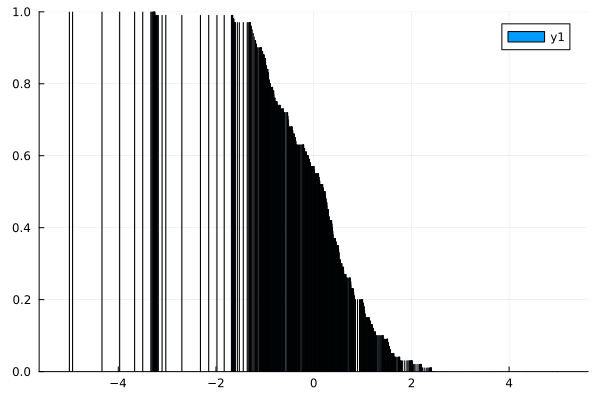

In [137]:
using Plots, StatsBase
g1 = randn(100)
gcdf = ecdf(g1)
plot(x ->1- gcdf(x),  seriestype=:bar, num_bins=10)

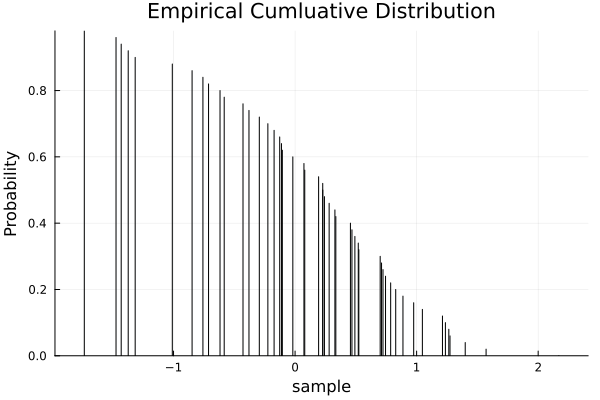

In [134]:
using Plots
n = 50
g1 = [randn() for i = 1:n] # generate the samples

p = plot(sort(g1), 1 .- (1:n)./n,
    xlabel = "sample", ylabel = "Probability",
    title = "Empirical Cumluative Distribution", label = "", seriestype=:bar, num_bins=10 )

In [118]:
using StatsBase
using HistogramTools

x = randn(10^2)
hist_obj = fit(Histogram, x, nbins=10)

# Extract bin edges
bin_edges = edges(hist_obj)


#plt=bar(x, y, label="Original Data", xlabel="X", ylabel="Y")

# Plot the modified data



LoadError: ArgumentError: Package HistogramTools not found in current path.
- Run `import Pkg; Pkg.add("HistogramTools")` to install the HistogramTools package.

In [117]:
Pkg.add("HistogramTools")

LoadError: The following package names could not be resolved:
 * HistogramTools (not found in project, manifest or registry)
[36m   Suggestions:[39m [0m[1mH[22m[0m[1mi[22m[0m[1ms[22m[0m[1mt[22m[0m[1mo[22m[0m[1mg[22m[0m[1mr[22m[0m[1ma[22m[0m[1mm[22m[0m[1mT[22mhresh[0m[1mo[22mlding

In [ ]:
plt=plot(x, y, label="Original Data", xlabel="X", ylabel="Y")

# Plot the modified data

collect(plt[1][1][:y])

11-element Vector{Float64}:
 2.0
 2.2
 2.4
 2.6
 2.8
 3.0
 3.2
 3.4
 3.6
 3.8
 4.0

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />